In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision.transforms import ToTensor

In [12]:
# Define the generator architecture
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, img_shape[0], kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z.view(z.size(0), self.latent_dim, 1, 1))
        return img


class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Conv2d(img_shape[0], 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity.view(img.size(0), -1)


In [13]:
# Initialize hyperparameters
latent_dim = 128
img_shape = (3, 64, 64)
batch_size = 128
num_epochs = 120
learning_rate = 0.0002

In [14]:
# Initialize the generator and discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)


In [15]:
# Define loss function and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


In [16]:
# Load and preprocess the dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = self._get_image_paths()

    def _get_image_paths(self):
        image_paths = []
        valid_extensions = [".jpg", ".jpeg", ".png"]
        for file_name in os.listdir(self.root_dir):
            ext = os.path.splitext(file_name)[-1].lower()
            if ext in valid_extensions:
                image_paths.append(os.path.join(self.root_dir, file_name))
        return sorted(image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

In [17]:
# Define the dataset directory
dataset_dir = "/content/data/class2"

# Define the desired image size
img_shape = (64, 64, 3)

# Define the batch size
#batch_size = 128

In [18]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((img_shape[1], img_shape[0])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the dataset and check if it contains any samples
dataset = CustomDataset(dataset_dir, transform=transform)
if len(dataset) == 0:
    raise ValueError("The dataset is empty.")

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [19]:
generator_losses = []
discriminator_losses = []

# Train the GAN
for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train the generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_images = generator(z)
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train the discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(gen_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %.4f] [G loss: %.4f]"
                % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        # Update the generator and discriminator losses
        generator_loss = g_loss.item()
        discriminator_loss = d_loss.item()
        generator_losses.append(generator_loss)
        discriminator_losses.append(discriminator_loss)

# Generate new images using the trained generator
z = torch.randn(batch_size, latent_dim).to(device)
gen_images = generator(z)

[Epoch 0/120] [Batch 0/1] [D loss: 0.7904] [G loss: 0.5747]
[Epoch 1/120] [Batch 0/1] [D loss: 0.4494] [G loss: 0.9805]
[Epoch 2/120] [Batch 0/1] [D loss: 0.2831] [G loss: 1.5081]
[Epoch 3/120] [Batch 0/1] [D loss: 0.1885] [G loss: 1.7380]
[Epoch 4/120] [Batch 0/1] [D loss: 0.1690] [G loss: 1.6680]
[Epoch 5/120] [Batch 0/1] [D loss: 0.1195] [G loss: 1.9402]
[Epoch 6/120] [Batch 0/1] [D loss: 0.1397] [G loss: 1.9336]
[Epoch 7/120] [Batch 0/1] [D loss: 0.1377] [G loss: 1.9862]
[Epoch 8/120] [Batch 0/1] [D loss: 0.1282] [G loss: 2.1477]
[Epoch 9/120] [Batch 0/1] [D loss: 0.0824] [G loss: 2.5326]
[Epoch 10/120] [Batch 0/1] [D loss: 0.1288] [G loss: 2.2235]
[Epoch 11/120] [Batch 0/1] [D loss: 0.0803] [G loss: 3.1494]
[Epoch 12/120] [Batch 0/1] [D loss: 0.1084] [G loss: 2.4910]
[Epoch 13/120] [Batch 0/1] [D loss: 0.1209] [G loss: 2.2854]
[Epoch 14/120] [Batch 0/1] [D loss: 0.0799] [G loss: 4.2868]
[Epoch 15/120] [Batch 0/1] [D loss: 0.0952] [G loss: 2.2283]
[Epoch 16/120] [Batch 0/1] [D loss

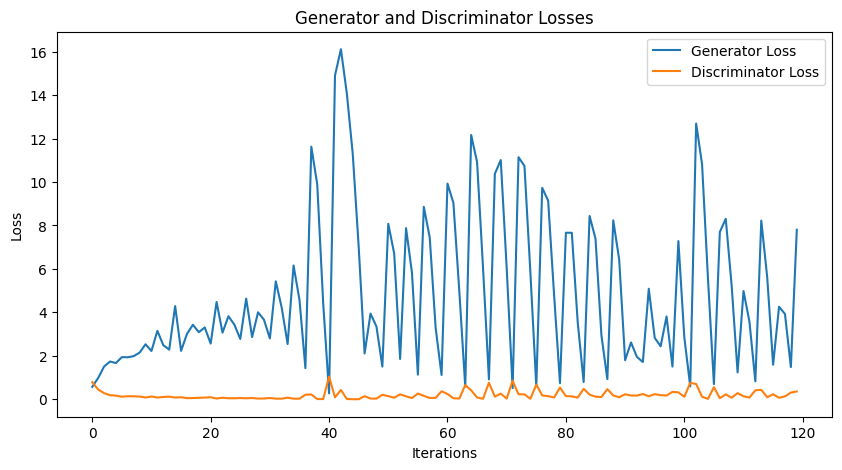

In [20]:
# Plot the generator and discriminator losses
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label="Generator Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Losses")
plt.legend()
plt.show()

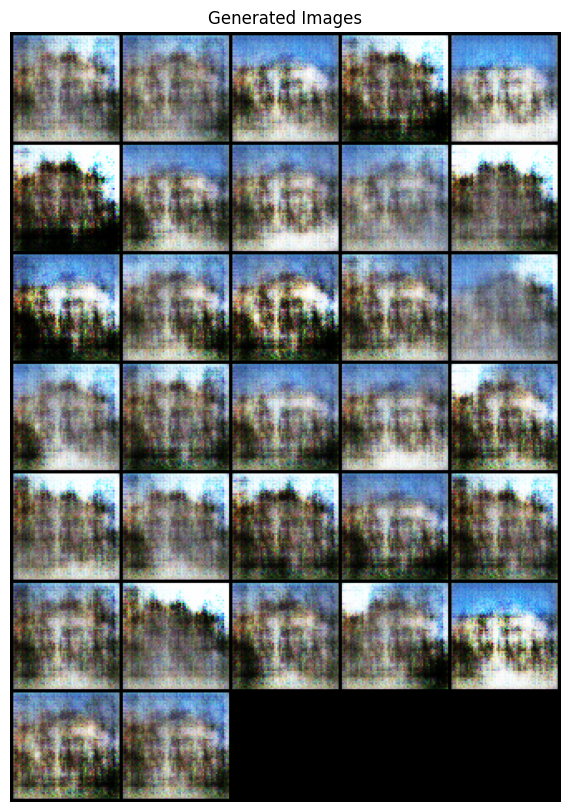

In [11]:
# Generate new images using the trained generator
z = torch.randn(batch_size, latent_dim).to(device)
gen_images = generator(z)

# Denormalize generated images
gen_images = (gen_images * 0.5) + 0.5

# Create a grid of generated images
grid = vutils.make_grid(gen_images.cpu(), nrow=int(batch_size**0.5), padding=2, normalize=True)

# Plot the generated images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [21]:


# Load the Inception v3 model pretrained on ImageNet
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.eval()

# Prepare the generated images for evaluation
gen_images = gen_images.cpu().detach()
gen_images = F.interpolate(gen_images, size=(299, 299), mode='bilinear', align_corners=False)
gen_images = (gen_images + 1) / 2  # Denormalize images

# Calculate the predictions for the generated images
with torch.no_grad():
    preds = inception_model(gen_images)

# Calculate the marginal entropy
marginal_entropy = torch.sum(-F.softmax(preds, dim=1) * F.log_softmax(preds, dim=1), dim=1).mean()

# Calculate the conditional entropy
preds = torch.softmax(preds, dim=1)
conditional_entropy = torch.sum(preds * torch.log(preds / preds.mean(dim=0, keepdim=True)), dim=1).mean()

# Calculate the Inception Score
inception_score = torch.exp(conditional_entropy - marginal_entropy)

print("Inception Score:", inception_score.item())


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 45.4MB/s] 


Inception Score: 0.010460219345986843
